In [1]:
import read, explore, preprocess, model

import tensorflow as tf
import os
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import imageio
from skimage.filters import gaussian
import geopandas as gpd

import importlib
importlib.reload(read)
importlib.reload(preprocess)

#make sure we are using the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


#### Get GLIMS IDs and the time series' dates

In [2]:
old_folder_path = os.path.join("C:\\","Users", "mattw","Desktop","projects","glacier_segmentation","time_series","old")
folders = next(os.walk(old_folder_path))[1]
ts_dict = {}
for folder in folders:
    ts_tifs = next(os.walk("{}/{}".format(old_folder_path,folder)))[2]
    ts_dict[folder] = ts_tifs
    #os.makedirs(r"C:\Users\mattw\Desktop\projects\glacier_segmentation\time_series\new\{}".format(folder))
glac_ids = folders
print(glac_ids)

['G006628E45300N', 'G006819E45785N', 'G006830E45811N', 'G006872E45809N', 'G006899E45830N', 'G007009E45873N', 'G007022E45508N', 'G007026E45991N', 'G007028E45901N', 'G007045E45487N', 'G007045E45907N', 'G007142E45337N', 'G007219E45477N', 'G007260E45523N', 'G007261E45966N', 'G007265E45549N', 'G007276E45599N', 'G007342E45528N', 'G007351E45541N', 'G007380E45524N', 'G007422E46008N', 'G007457E45957N', 'G007561E46022N', 'G007581E45956N', 'G007581E46002N', 'G007603E46067N', 'G007663E45970N', 'G007702E46120N', 'G007761E45922N', 'G007794E45916N', 'G007807E46481N', 'G007846E45906N', 'G007858E45898N', 'G007867E46119N', 'G007880E45990N', 'G007882E45908N', 'G007887E45948N', 'G007908E45948N', 'G007930E46472N', 'G008006E46177N', 'G008010E46463N', 'G008051E46566N', 'G008087E46260N', 'G008132E61573N', 'G008185E46529N', 'G008203E46301N', 'G008297E46408N', 'G008319E46431N', 'G008426E46612N', 'G009038E46502N', 'G009741E46261N', 'G009753E46263N', 'G009837E46351N', 'G009886E46384N', 'G009895E46391N', 'G014028E

#### Read the time series images of the glaciers we want to estimate area with

In [3]:
new_folder_path = os.path.join("C:\\","Users", "mattw","Desktop","projects","glacier_segmentation","time_series","new/")
#glaciers_to_estimate_area = glac_ids
glaciers_to_estimate_area = ["G007026E45991N"]
ts_dates_load,ts_rasters = read.ts_get_images(new_folder_path,glaciers_to_estimate_area)
print(glaciers_to_estimate_area)

['G007026E45991N']


#### Obtain helpful metadata on the glaciers

In [4]:
image_shapes = [raster[0].shape[1:3] for raster in ts_rasters]
conversion_factor = [(shape[0]*shape[1])/(128*128) for shape in image_shapes]
glaciers_df = pd.DataFrame({'ID': glaciers_to_estimate_area,
                            'shape':image_shapes,
                            'scale':conversion_factor})


glac_id_dict = dict(zip(folders,range(0,len(folders))))
shape_dict = dict(zip(glaciers_df['ID'],glaciers_df['shape']))
scale_dict = dict(zip(glaciers_df['ID'],glaciers_df['scale']))

#### Load the model

In [6]:
tf_model = tf.keras.models.load_model("models/largest_ee.h5", compile = False)

#### Preprocess the data, fit the model, and create gifs

Time series images for G007026E45991N:  615
(615, 256, 256, 6)
Times series images after filtering:  615
Time series of smoothed images: 


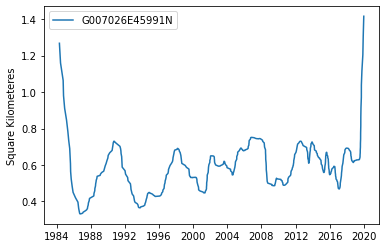

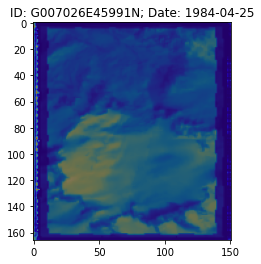

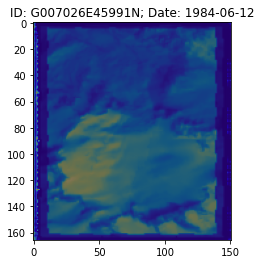

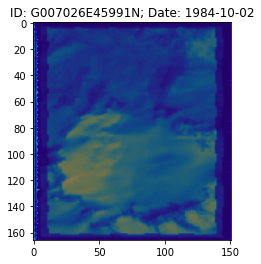

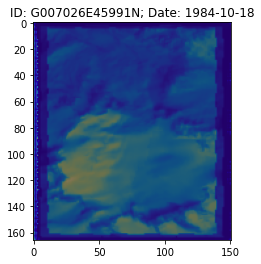

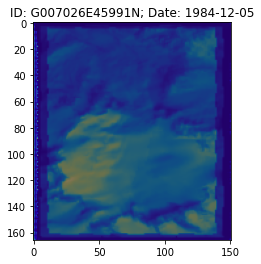

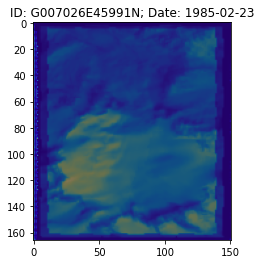

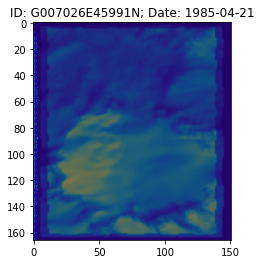

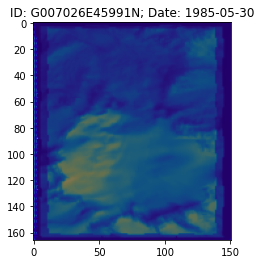

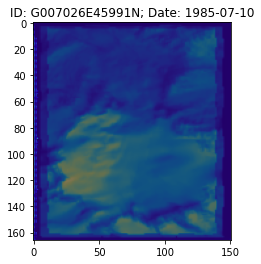

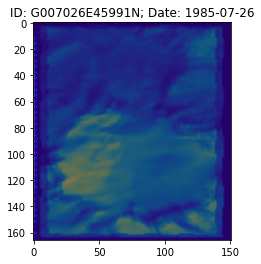

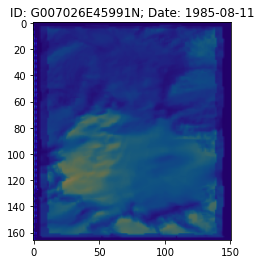

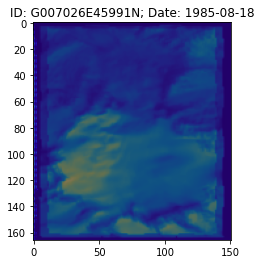

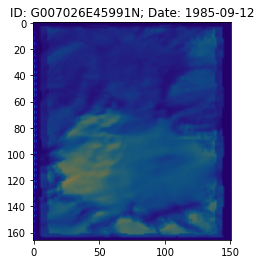

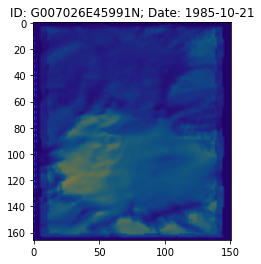

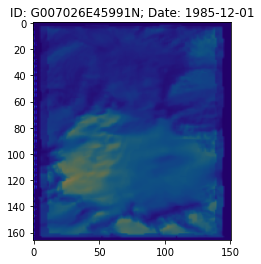

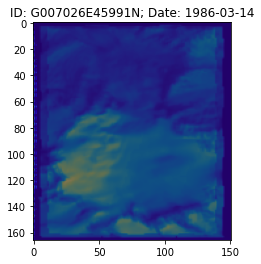

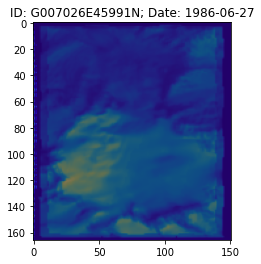

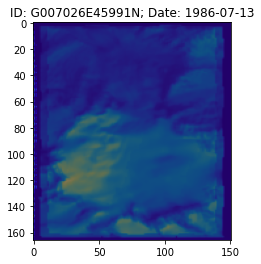

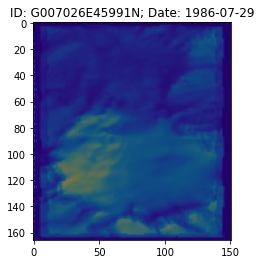

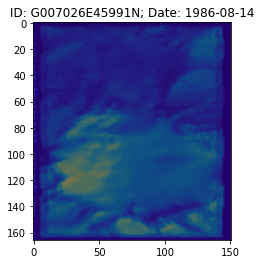

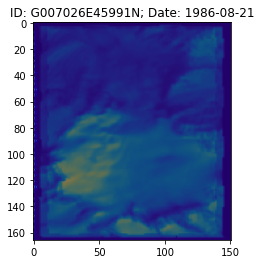

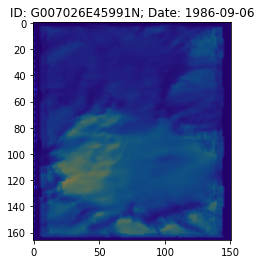

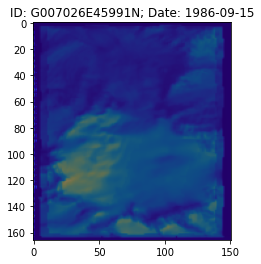

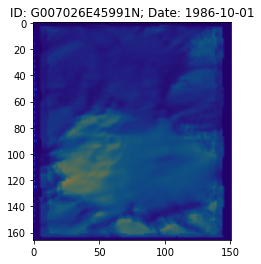

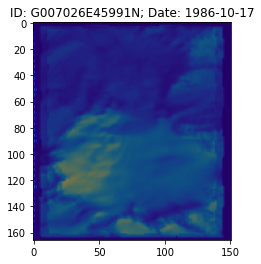

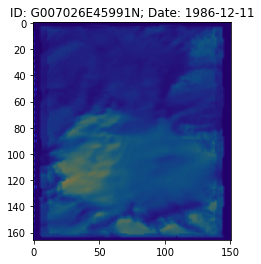

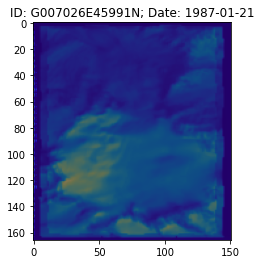

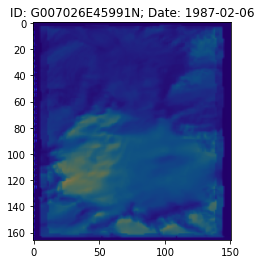

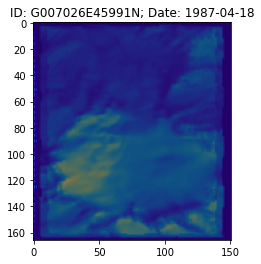

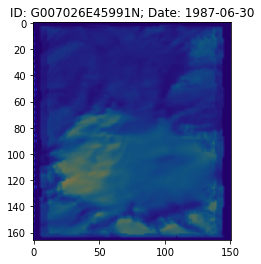

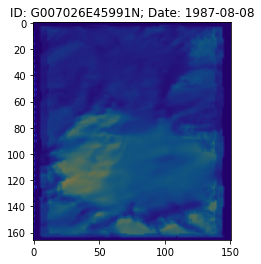

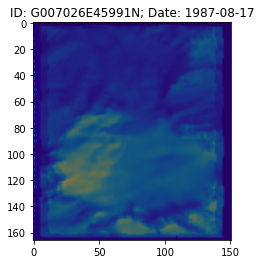

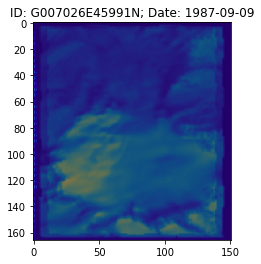

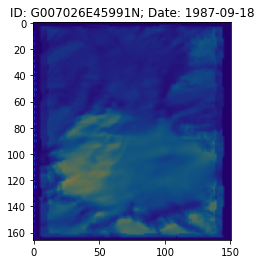

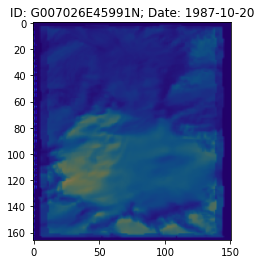

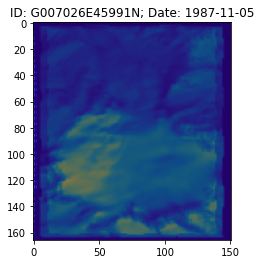

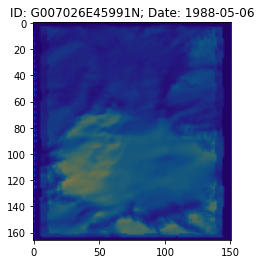

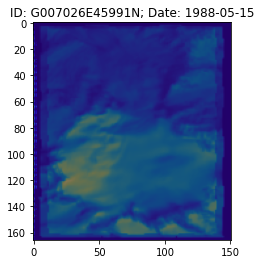

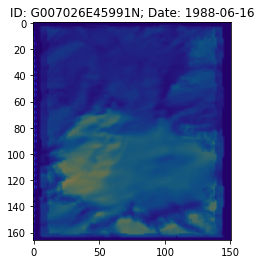

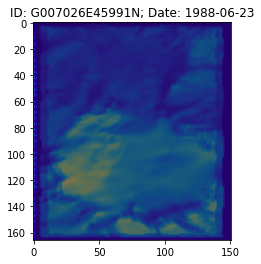

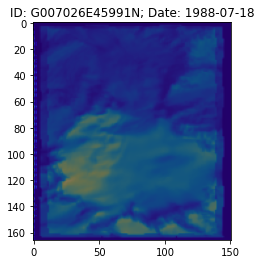

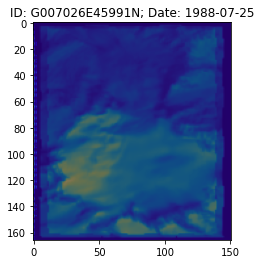

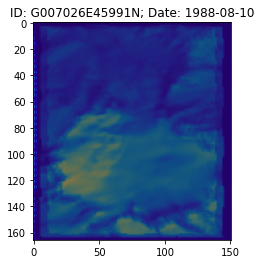

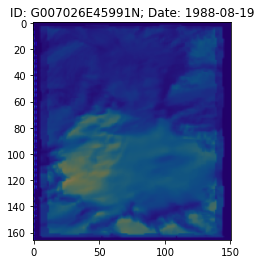

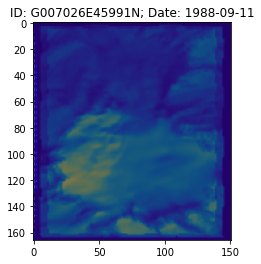

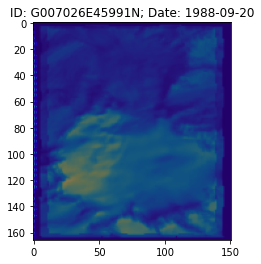

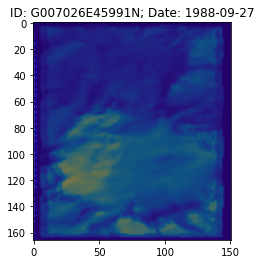

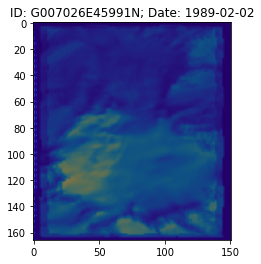

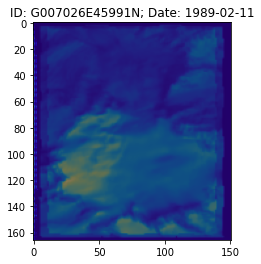

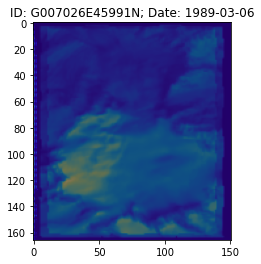

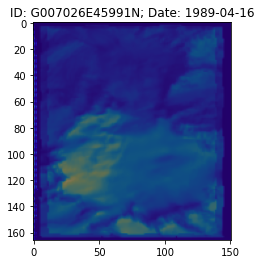

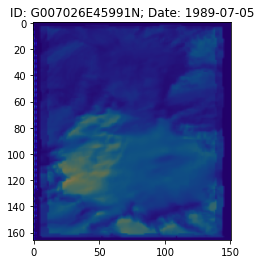

KeyboardInterrupt: 

In [11]:
for i in range(0,1):
    print('Time series images for {}: '.format(glaciers_to_estimate_area[i]), len(ts_rasters[i]))

    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    IMG_CHANNELS = {'blue':0,
                    'green':1,
                    'red':2,
                    'NIR':3,
                    'SWIR1':4,
                    'Thermal':5}


    dim = (IMG_HEIGHT, IMG_WIDTH)
    
    rasters = ts_rasters[i]
    dates = ts_dates_load[i]

    X_eval_ts = preprocess.resize_and_clean_images(rasters, dim) #resizing image to fit model
    X_clean, dates_clean = preprocess.clean_ts(X_eval_ts, np.array(dates),tf_model,glaciers_to_estimate_area[0]) #cleaning training images and dates
    print(X_clean.shape)
    
    print('Times series images after filtering: ', X_clean.shape[0])
    
    if X_clean.shape[0] != 0:
        
        #smooth the raster images then fit the model and compute area
        smoothed_rasters = gaussian(X_clean, sigma = [8,0,0,0])
        pred_ts = tf_model.predict(smoothed_rasters)
        area = pred_ts.sum(axis=(1,2,3))*900*scale_dict[glaciers_to_estimate_area[i]]
        area = area/1000000
        
        #resize images and masms to original shapes
        original_dim = shape_dict[glaciers_to_estimate_area[i]]
        smoothed_rasters = np.array(tf.image.resize(smoothed_rasters, original_dim))
        pred_ts = np.array(tf.image.resize(pred_ts, original_dim)) #bring mask back to original image shape
        
        #plot the time series of the model
        print('Time series of smoothed images: ')
        plt.plot(dates_clean,area, label = glaciers_to_estimate_area[i])
        plt.ylabel("Square Kilometeres")
        plt.legend()
        plt.show()
        
        #write the dates and areas as a CSV file
        #clean_df = pd.DataFrame({'date':dates_clean, 'area':area})
        #clean_df.to_csv("R/date_area_{}.csv".format(glaciers_to_estimate_area[i]))
    
        #create gifs of the masks
        to_omit = set(dates)-set(dates_clean)
        j = 0
        skipped = 0
        for idx,dat in enumerate(dates):
            if dat in to_omit:
                continue
                skipped += 1
            plt.imshow(smoothed_rasters[j,:,:,3], alpha = 1)
            plt.imshow(pred_ts[j,:,:,0], cmap = "jet", alpha = 0.5)
            plt.title('ID: {}; Date: {}'.format(glaciers_to_estimate_area[i],dat))
            plt.savefig(r"C:\Users\mattw\Desktop\projects\glacier_segmentation\gifs\make_gif\{}.png".format(j))
            j += 1
            plt.show()
        with imageio.get_writer(r"C:\Users\mattw\Desktop\projects\glacier_segmentation\gifs\smoothed\{}.gif".format("trient_gif_1million"), mode = "I") as writer:
            for i in range(len(dates_clean)):
                image = imageio.imread(r"C:\Users\mattw\Desktop\projects\glacier_segmentation\gifs\make_gif\{}.png".format(i))
                writer.append_data(image)
        for i in range(len(dates_clean)):
            os.remove(r"C:\Users\mattw\Desktop\projects\glacier_segmentation\gifs\make_gif\{}.png".format(i))